In [1]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12070604186769766662, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7386457533402831773
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1774279613862598936
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15864515789
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8397216354946057721
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [145]:
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.recurrent import LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam , SGD
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
# from keras.regularizers import ActivityRegularizer
from keras import backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import numpy as np
from keras.layers import Dense,Lambda


smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
  
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):

    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

"""
# Create simple model
from keras.layers import Conv2D, Reshape
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(64, 5, activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(128, 5, activation='relu', padding='same'))
model.add(Conv2D(1, 5, activation='sigmoid', padding='same'))
model.add(Reshape((128, 128)))
          
model.compile(Adam(lr=0.01), loss=bce_dice_loss, metrics=[dice_coef])     
"""
def segnet(nClasses, input_height=512, input_width=512):

    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    model = Sequential()
    model.add(Layer(input_shape=(input_height , input_width,3)))

    # encoder
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))


    # decoder
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(512, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())

    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(256, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())

    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(128, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())

    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())


    model.add(Convolution2D( nClasses , 1, 1, border_mode='valid',))
    
    model.outputHeight = model.output_shape[-2]
    model.outputWidth = model.output_shape[-1]

    #model.add(Reshape((model.output_shape[-2]*model.output_shape[-1], nClasses), input_shape=(model.output_shape[-2], model.output_shape[-1]  )))
    #model.add(Permute((2, 1)))
    model.add(Activation('softmax'))
    #model.add(Lambda(lambda x: K.argmax(x)))
    #model.add(Lambda(lambda x: K.cast(x,"int")))
    #if not optimizer is None:
    model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])

    return model
    




In [173]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from keras.models import Model
from keras.regularizers import l2
from keras.layers import *
from keras.engine import Layer
from keras.applications.vgg16 import *
from keras.models import *
import keras.backend as K
import tensorflow as tf


def FCN_Vgg16_32s(input_shape=None, weight_decay=0., batch_momentum=0.9, batch_shape=None, classes=2):
    if batch_shape:
        img_input = Input(batch_shape=batch_shape)
        image_size = batch_shape[1:3]
    else:
        img_input = Input(shape=input_shape)
        image_size = input_shape[0:2]
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(256, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(256, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128, (7, 7), activation='relu', padding='same', name='fc3', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128, (1, 1), activation='relu', padding='same', name='fc4', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(64, (7, 7), activation='relu', padding='same', name='fc5', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(64, (1, 1), activation='relu', padding='same', name='fc6', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    #classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (x)
   

    model = Model(img_input, outputs)

    return model

In [161]:
from glob import glob
import os

path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)
print(train_img_paths[:10])
print(train_mask_paths[:10])


path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
print(val_img_paths[:5])

['train/10729_sat.jpg', 'train/51187_sat.jpg', 'train/52299_sat.jpg', 'train/4962_sat.jpg', 'train/13549_sat.jpg', 'train/15363_sat.jpg', 'train/38456_sat.jpg', 'train/50517_sat.jpg', 'train/32252_sat.jpg', 'train/12993_sat.jpg']
['train/12895_msk.png', 'train/23379_msk.png', 'train/19799_msk.png', 'train/2575_msk.png', 'train/50807_msk.png', 'train/41694_msk.png', 'train/9457_msk.png', 'train/34365_msk.png', 'train/47347_msk.png', 'train/21599_msk.png']
['val/70036_sat.jpg', 'val/75729_sat.jpg', 'val/78249_sat.jpg', 'val/76288_sat.jpg', 'val/71029_sat.jpg']


In [147]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(512, 512)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) #/ 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask

In [174]:
model = FCN_Vgg16_32s((512,512,3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [21]:
#compute average image

average = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    average = np.add(average, img)
average = average/10897

In [23]:
#compute standard deviation image

sd = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    a = np.subtract(img, average)
    a = np.square(a)
    sd = np.add(sd, a)
sd = sd/10897
sd = np.sqrt(sd)


In [88]:
print (sd)

[[[ 40.41082667  32.25589746  30.80810358]
  [ 40.07896065  31.89023177  30.40830101]
  [ 40.39878584  32.33384431  30.82290725]
  ..., 
  [ 40.47686276  32.31425617  30.78016282]
  [ 40.42960732  32.20080082  30.6607908 ]
  [ 40.61248159  32.3660722   30.8595762 ]]

 [[ 40.12767114  32.06398593  30.56245447]
  [ 39.87489401  31.82907065  30.3692613 ]
  [ 40.15589891  32.13324647  30.62535854]
  ..., 
  [ 40.14705256  32.01550519  30.50772375]
  [ 40.09326625  31.87761547  30.37449059]
  [ 40.25014628  31.99787813  30.47001007]]

 [[ 40.18354043  32.18617777  30.5820286 ]
  [ 39.94309981  31.95973407  30.40409358]
  [ 40.15804531  32.19126586  30.60119408]
  ..., 
  [ 40.27019059  32.1806527   30.61388328]
  [ 40.19098308  32.03460514  30.45726627]
  [ 40.38486663  32.21967474  30.64666009]]

 ..., 
 [[ 40.38854176  32.27642034  30.37098629]
  [ 40.2094635   32.10089655  30.21412687]
  [ 40.39702093  32.39041923  30.54226738]
  ..., 
  [ 39.95118094  31.85077672  30.10270294]
  [ 39.84

In [89]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            img = np.divide((img - average),sd) #0 mean, 1 var
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []


In [90]:
from sklearn.model_selection import train_test_split
import keras.callbacks
BATCHSIZE = 32

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.15)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

filepath="unet.hdf5"

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]
# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs= 20, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5, # Change this number based on memory restrictions
    callbacks = callbacks_list 
)

ValueError: An operation has `None` for gradient. Please make sure that all of your ops have a gradient defined (i.e. are differentiable). Common ops without gradient: K.argmax, K.round, K.eval.

In [12]:
import numpy as np
import pandas as pd

# Create submission DataFrame
def create_submission(csv_name, predictions_gen):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> generator that yields a pair of id, prediction
    """
    sub = pd.DataFrame()
    ids = []
    encodings = []
    num_images = len(val_img_paths)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        img_id, pred = next(predictions_gen)
        ids.append(img_id)
        #print (np.count_nonzero(pred == 1))
        encodings.append(rle_encoding(pred))
        
    sub['EncodedPixels'] = encodings
    sub['ImageId'] = ids
    sub.to_csv(csv_name, index=False)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [13]:

def generate_pixel_by_pixel_predictions_generator(val_paths):
    for img_path in val_paths:        
        img = imread(img_path)
        img = resize(img, (512, 512), preserve_range=True) 
        img = np.divide((img - average),sd) #0 mean, 1 var
        y = model.predict(img.reshape(1,512,512,3))  
        y = (y >= 0.5).astype(float) #IMPORTANT- need this or you won't have 0 or 1 (because outputs are probabilities!!)
        yield get_img_id(img_path), y.reshape(512, 512)

In [14]:
import time
import matplotlib.pyplot as plt
path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')
train_img_paths = glob(glob_train_imgs)
path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)


#first_img, first_mask = next(ig)
"""
img_size = (128,128)
for i in range(30,50): 
    
    img_id = get_img_id(train_img_paths[i])
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
           
    img = imread(train_img_paths[i]) / 255.
    mask = rgb2gray(imread(mask_path))
    img = resize(img, img_size, preserve_range=True)
    mask = resize(mask, img_size, mode='constant', preserve_range=True)    
    mask = (mask >= 0.5).astype(float)
    
    plt.imshow(mask, cmap='gray')
    plt.show()
    
    y = model.predict(img.reshape(1,128,128,3)) 
    y = (y.reshape(128,128) >= 0.5).astype(float)
    
    plt.imshow(y, cmap='gray')
    plt.show()
    
    
    
    img = imread(val_img_paths[i]) / 255.
    img = resize(img, (128, 128), preserve_range=True)  
    print (get_img_id(val_img_paths[i]))
    y = model.predict(img.reshape(1,128,128,3)) 
    y = (y >= 0.5).astype(float)
    #print (np.count_nonzero(y == 1))
    #print (y)
    plt.imshow(y.reshape(128,128), cmap='gray')
    plt.show()
"""



tic = time.time()
create_submission("unet.csv", generate_pixel_by_pixel_predictions_generator(val_img_paths))
toc = time.time()
print(toc - tic)


215 2169
431 2169
647 2169
863 2169
1079 2169
1295 2169
1511 2169
1727 2169
1943 2169
2159 2169
119.65486407279968


NameError: name 'plot' is not defined

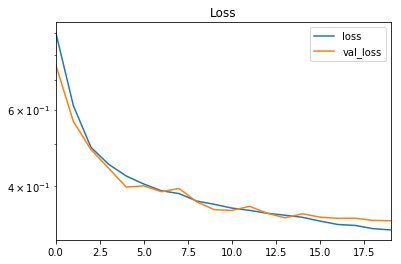

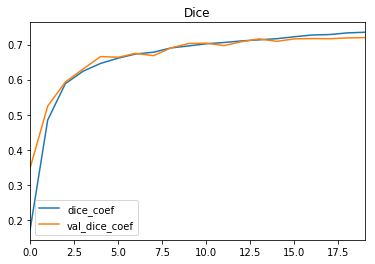

In [20]:
import pandas as pd
%matplotlib inline

# Plot the training curve
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot(title="Dice")
